# Cell type identification with ScanPy

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scrublet as scr
import matplotlib.pyplot as plt

from scipy import sparse
import loompy as lp
from loomxpy._loomx import LoomX

In [44]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [46]:
adata = sc.read_10x_h5('data/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [47]:
adata

AnnData object with n_obs × n_vars = 12012 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

## Pre-processing

### Filtering by count depth & number of genes per barcode

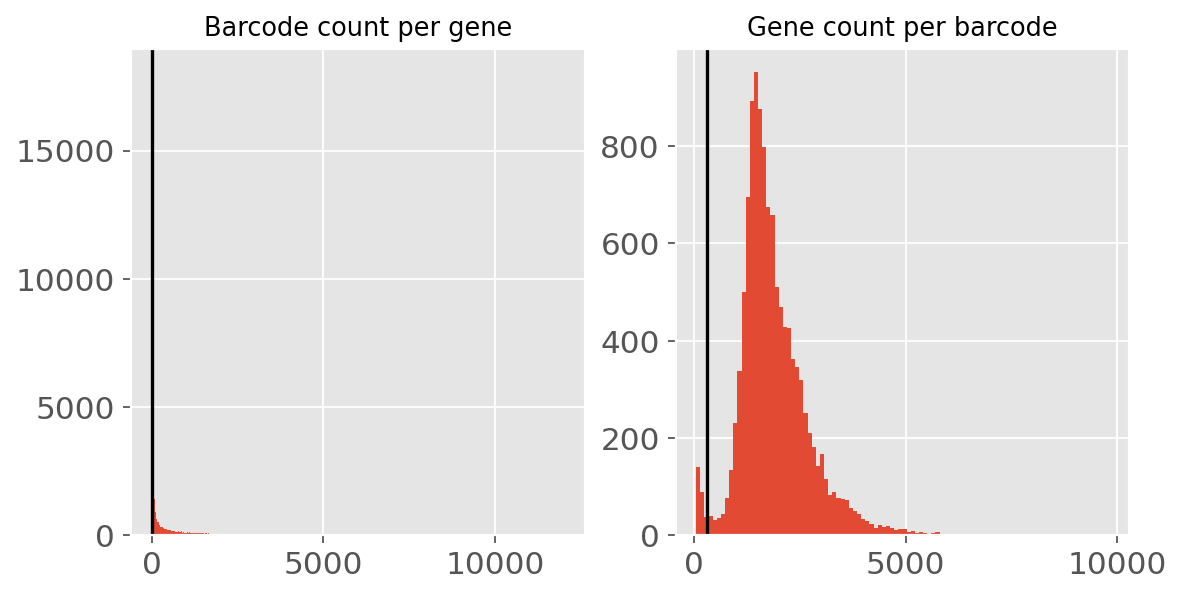

In [48]:
adata_qc = sc.pp.calculate_qc_metrics(adata)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 8
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(adata_qc[1]['n_cells_by_counts'],bins='auto')
ax1.axvline(x=3, color='black', linestyle='-')
ax1.set_title("Barcode count per gene")

ax2.hist(adata_qc[0]['n_genes_by_counts'], bins=100)
ax2.axvline(x=300, color='black', linestyle='-')
ax2.set_title("Gene count per barcode")

plt.show()
plt.close()

In [49]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 254 cells that have less than 300 genes expressed
filtered out 9527 genes that are detected in less than 3 cells


### Filter by fraction of mitochondrial genes per barcode & no. of genes per barcode

In [50]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'feature_types' as categorical
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'genome' as categorical


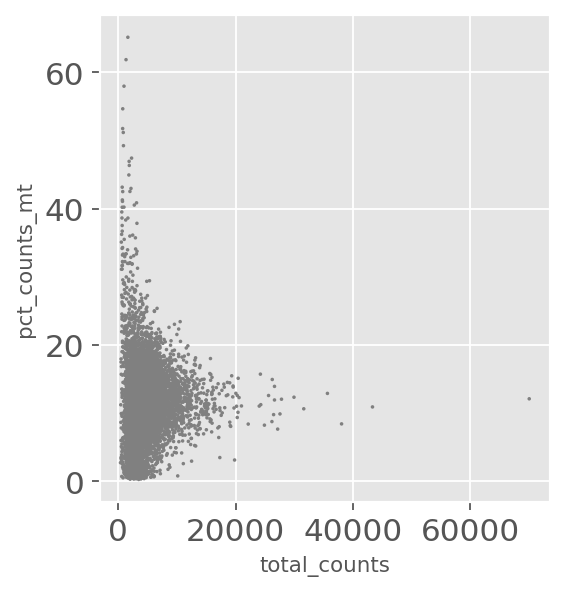

In [51]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [52]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

### Filter doublets

In [53]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.15, random_state = 1)

In [54]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(n_prin_comps=40)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 13.9%
Estimated detectable doublet fraction = 75.9%
Overall doublet rate:
	Expected   = 15.0%
	Estimated  = 18.3%
Elapsed time: 15.7 seconds


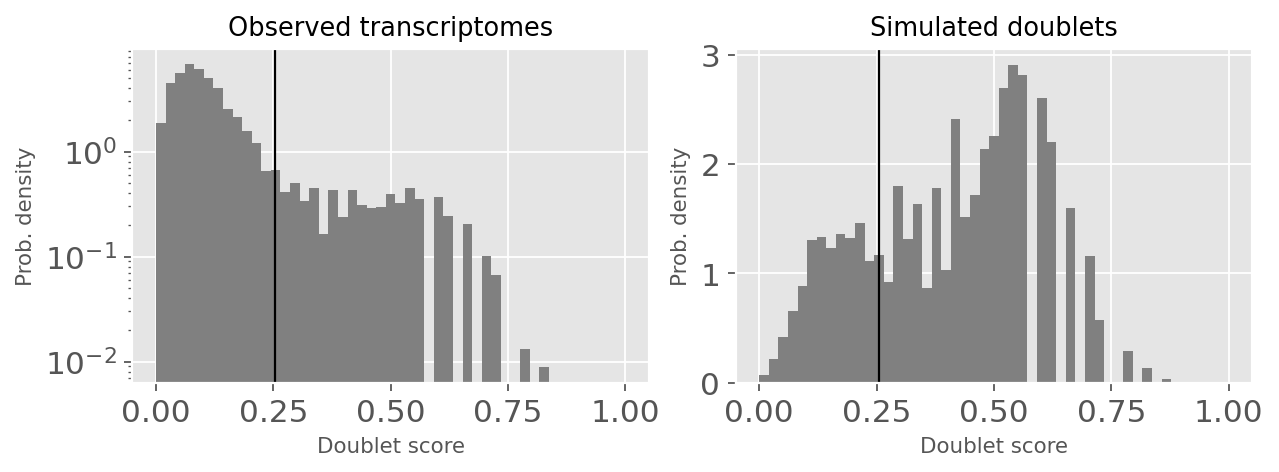

In [55]:
scrub.plot_histogram();

In [56]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

In [57]:
adata.obs['doublet_scores'] = doublet_scores
adata = adata[~predicted_doublets,:]

Trying to set attribute `.obs` of view, copying.


### Count normalization

In [58]:
sc.pp.normalize_total(adata, target_sum=1e4)

Revieved a view of an AnnData. Making a copy.


normalizing counts per cell
    finished (0:00:00)


In [59]:
sc.pp.log1p(adata)

### Select highly variable genes

In [60]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)


In [61]:
sc.pl.highly_variable_genes(adata)

In [62]:
adata.raw = adata

In [63]:
adata = adata[:, adata.var.highly_variable]

### Regress out biological covariates (optional)

In [64]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

### Gene normalization

In [65]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Revieved a view of an AnnData. Making a copy.


## Dimensionality Reduction

### Principal Component Analysis (PCA)

In [66]:
sc.tl.pca(adata, svd_solver='arpack', random_state = 1)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


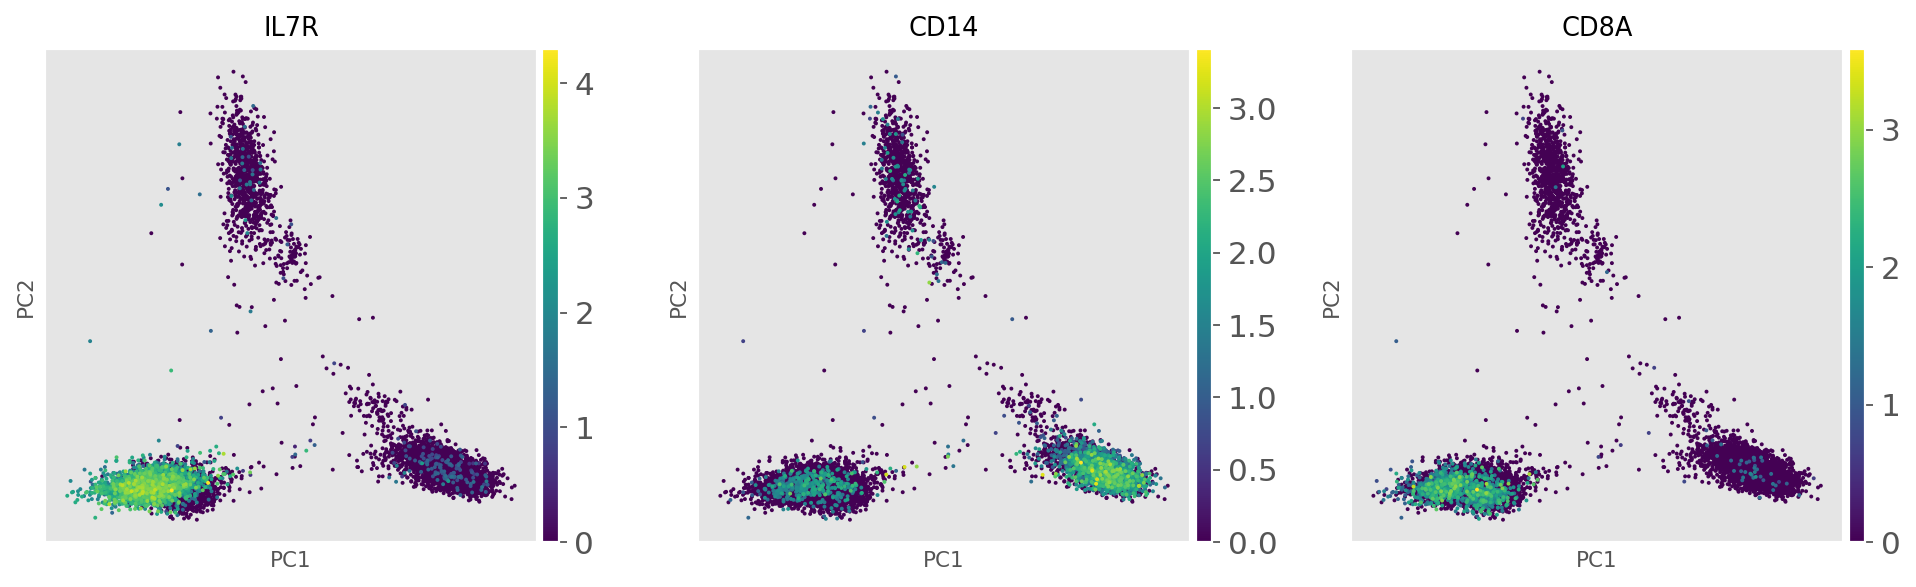

In [67]:
sc.pl.pca(adata, color=['IL7R', 'CD14', 'CD8A'])

In [68]:
sc.pl.pca_variance_ratio(adata, log=True)

### Constructing & Embedding the neighbourhood graph (UMAP)

In [69]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, random_state = 1)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:01)


In [71]:
sc.tl.umap(adata, random_state = 1)

computing UMAP
    finished (0:00:23)


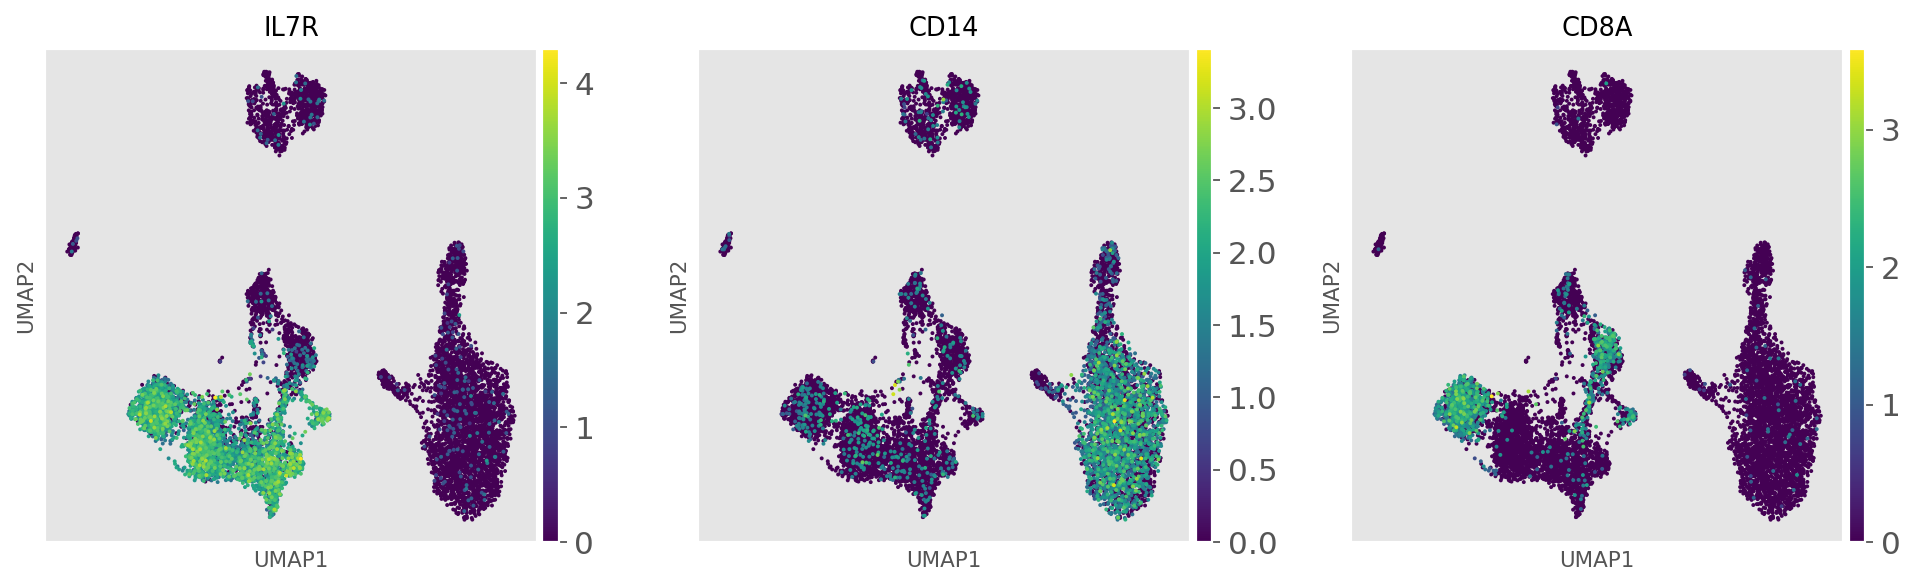

In [72]:
sc.pl.umap(adata, color=['IL7R', 'CD14', 'CD8A'])

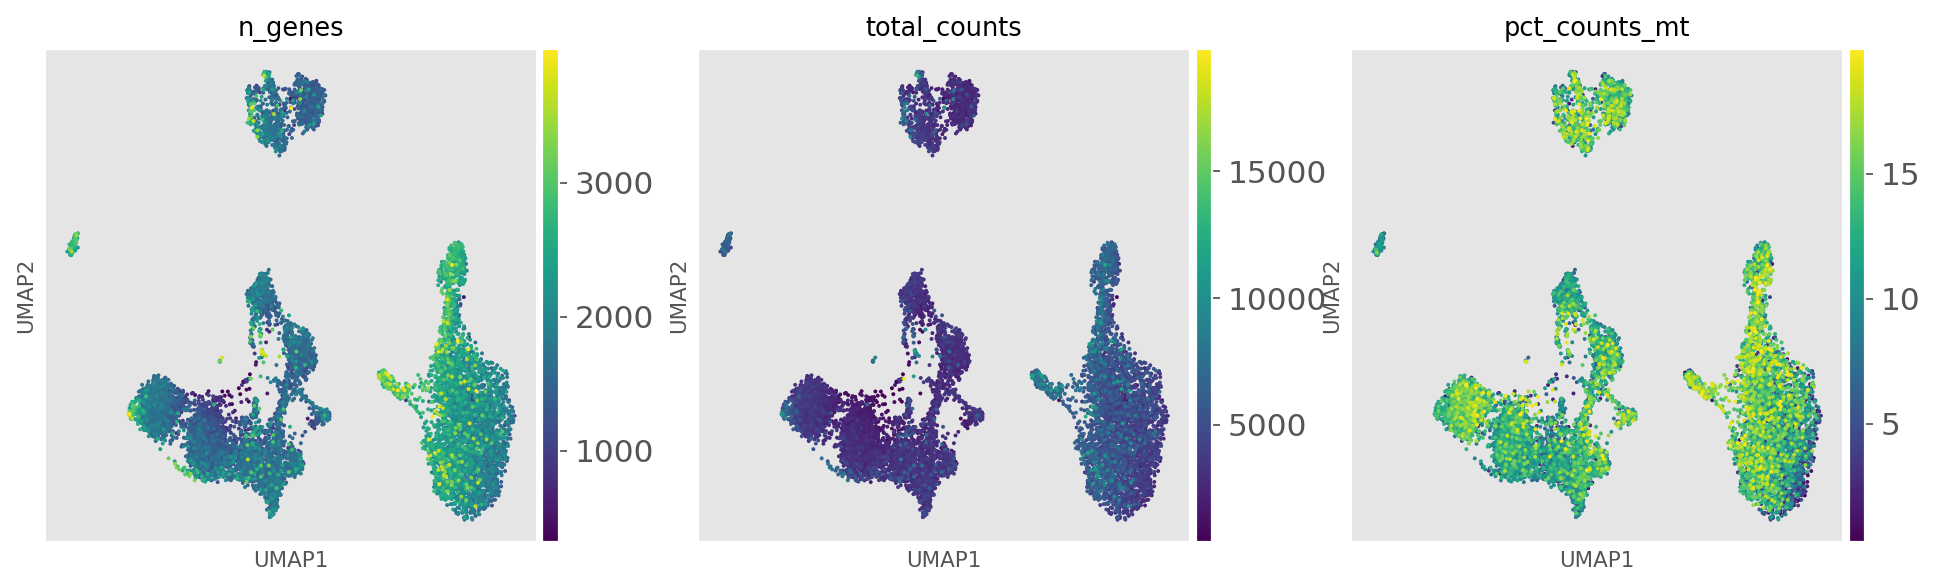

In [73]:
sc.pl.umap(adata, color=['n_genes','total_counts','pct_counts_mt'])

## Cell Identity Identification

### Leiden Clustering

In [74]:
for i in np.arange(0.1,0.5,0.1):
    sc.tl.leiden(adata, resolution=i, key_added="leiden_"+str(i)[:3], random_state = 1)

running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


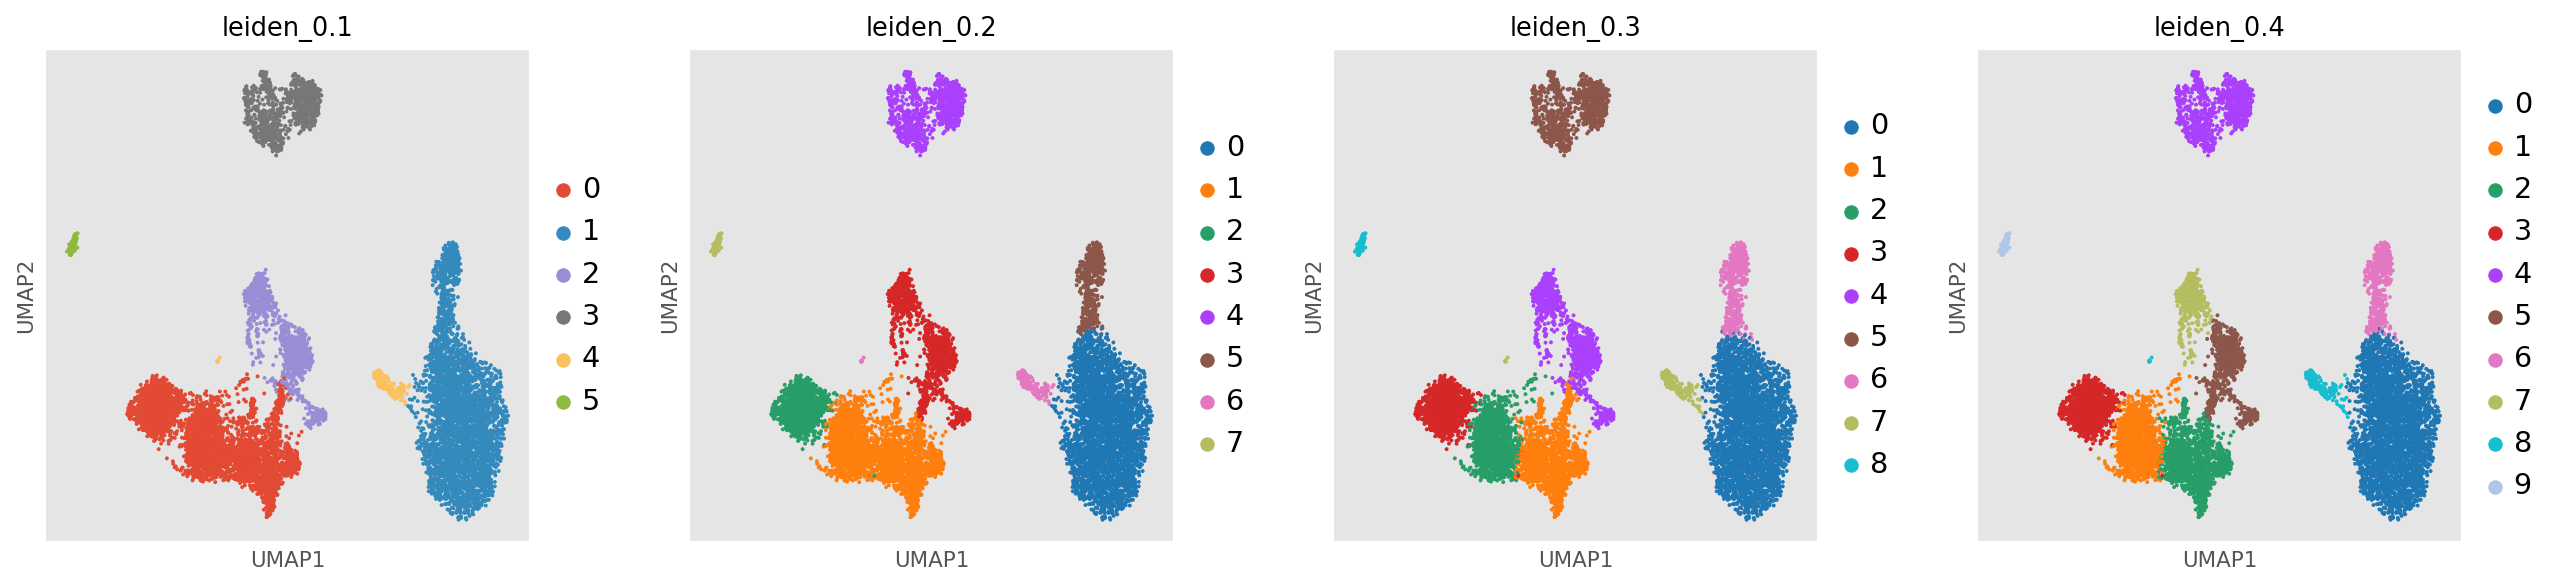

In [75]:
sc.pl.umap(adata, color=['leiden_' + str(i)[:3] for i in np.arange(0.1,0.5,0.1)])

### Marker Gene Identification

From pbmc3k tutorial:

Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

In [76]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:15)


In [77]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1       2       3     4        5       6         7  \
0  PLXDC2    INPP4B    LEF1    LEF1  NKG7    BANK1  TCF7L2      CST3   
1    DPYD  ARHGAP15    FHIT  THEMIS  GNLY     AFF3    PSAP  HLA-DRB1   
2    VCAN     SYNE2  BCL11B   NELL2  CCL5  RALGPS2   MTSS1  HLA-DPB1   
3   NEAT1    CDC14A   CAMK4   PDE3B  PRF1     PAX5  FCGR3A   HLA-DRA   
4   LRMDA      ANK3    ANK3   BACH2  GZMA    MS4A1  IFITM3      CD74   

            8  
0        TCF4  
1        CUX2  
2  AC023590.1  
3        ZFAT  
4      CCDC50

In [78]:
marker_genes = ['IL7R', 'LYZ', 'CD14', 'CD8A', 'CD8B',
                'GNLY', 'NKG7', 'CD79A', 'MS4A1', 'FCGR3A',  
                'MS4A7', 'FCER1A', 'CST3', 'PPBP', 'IGLL1']

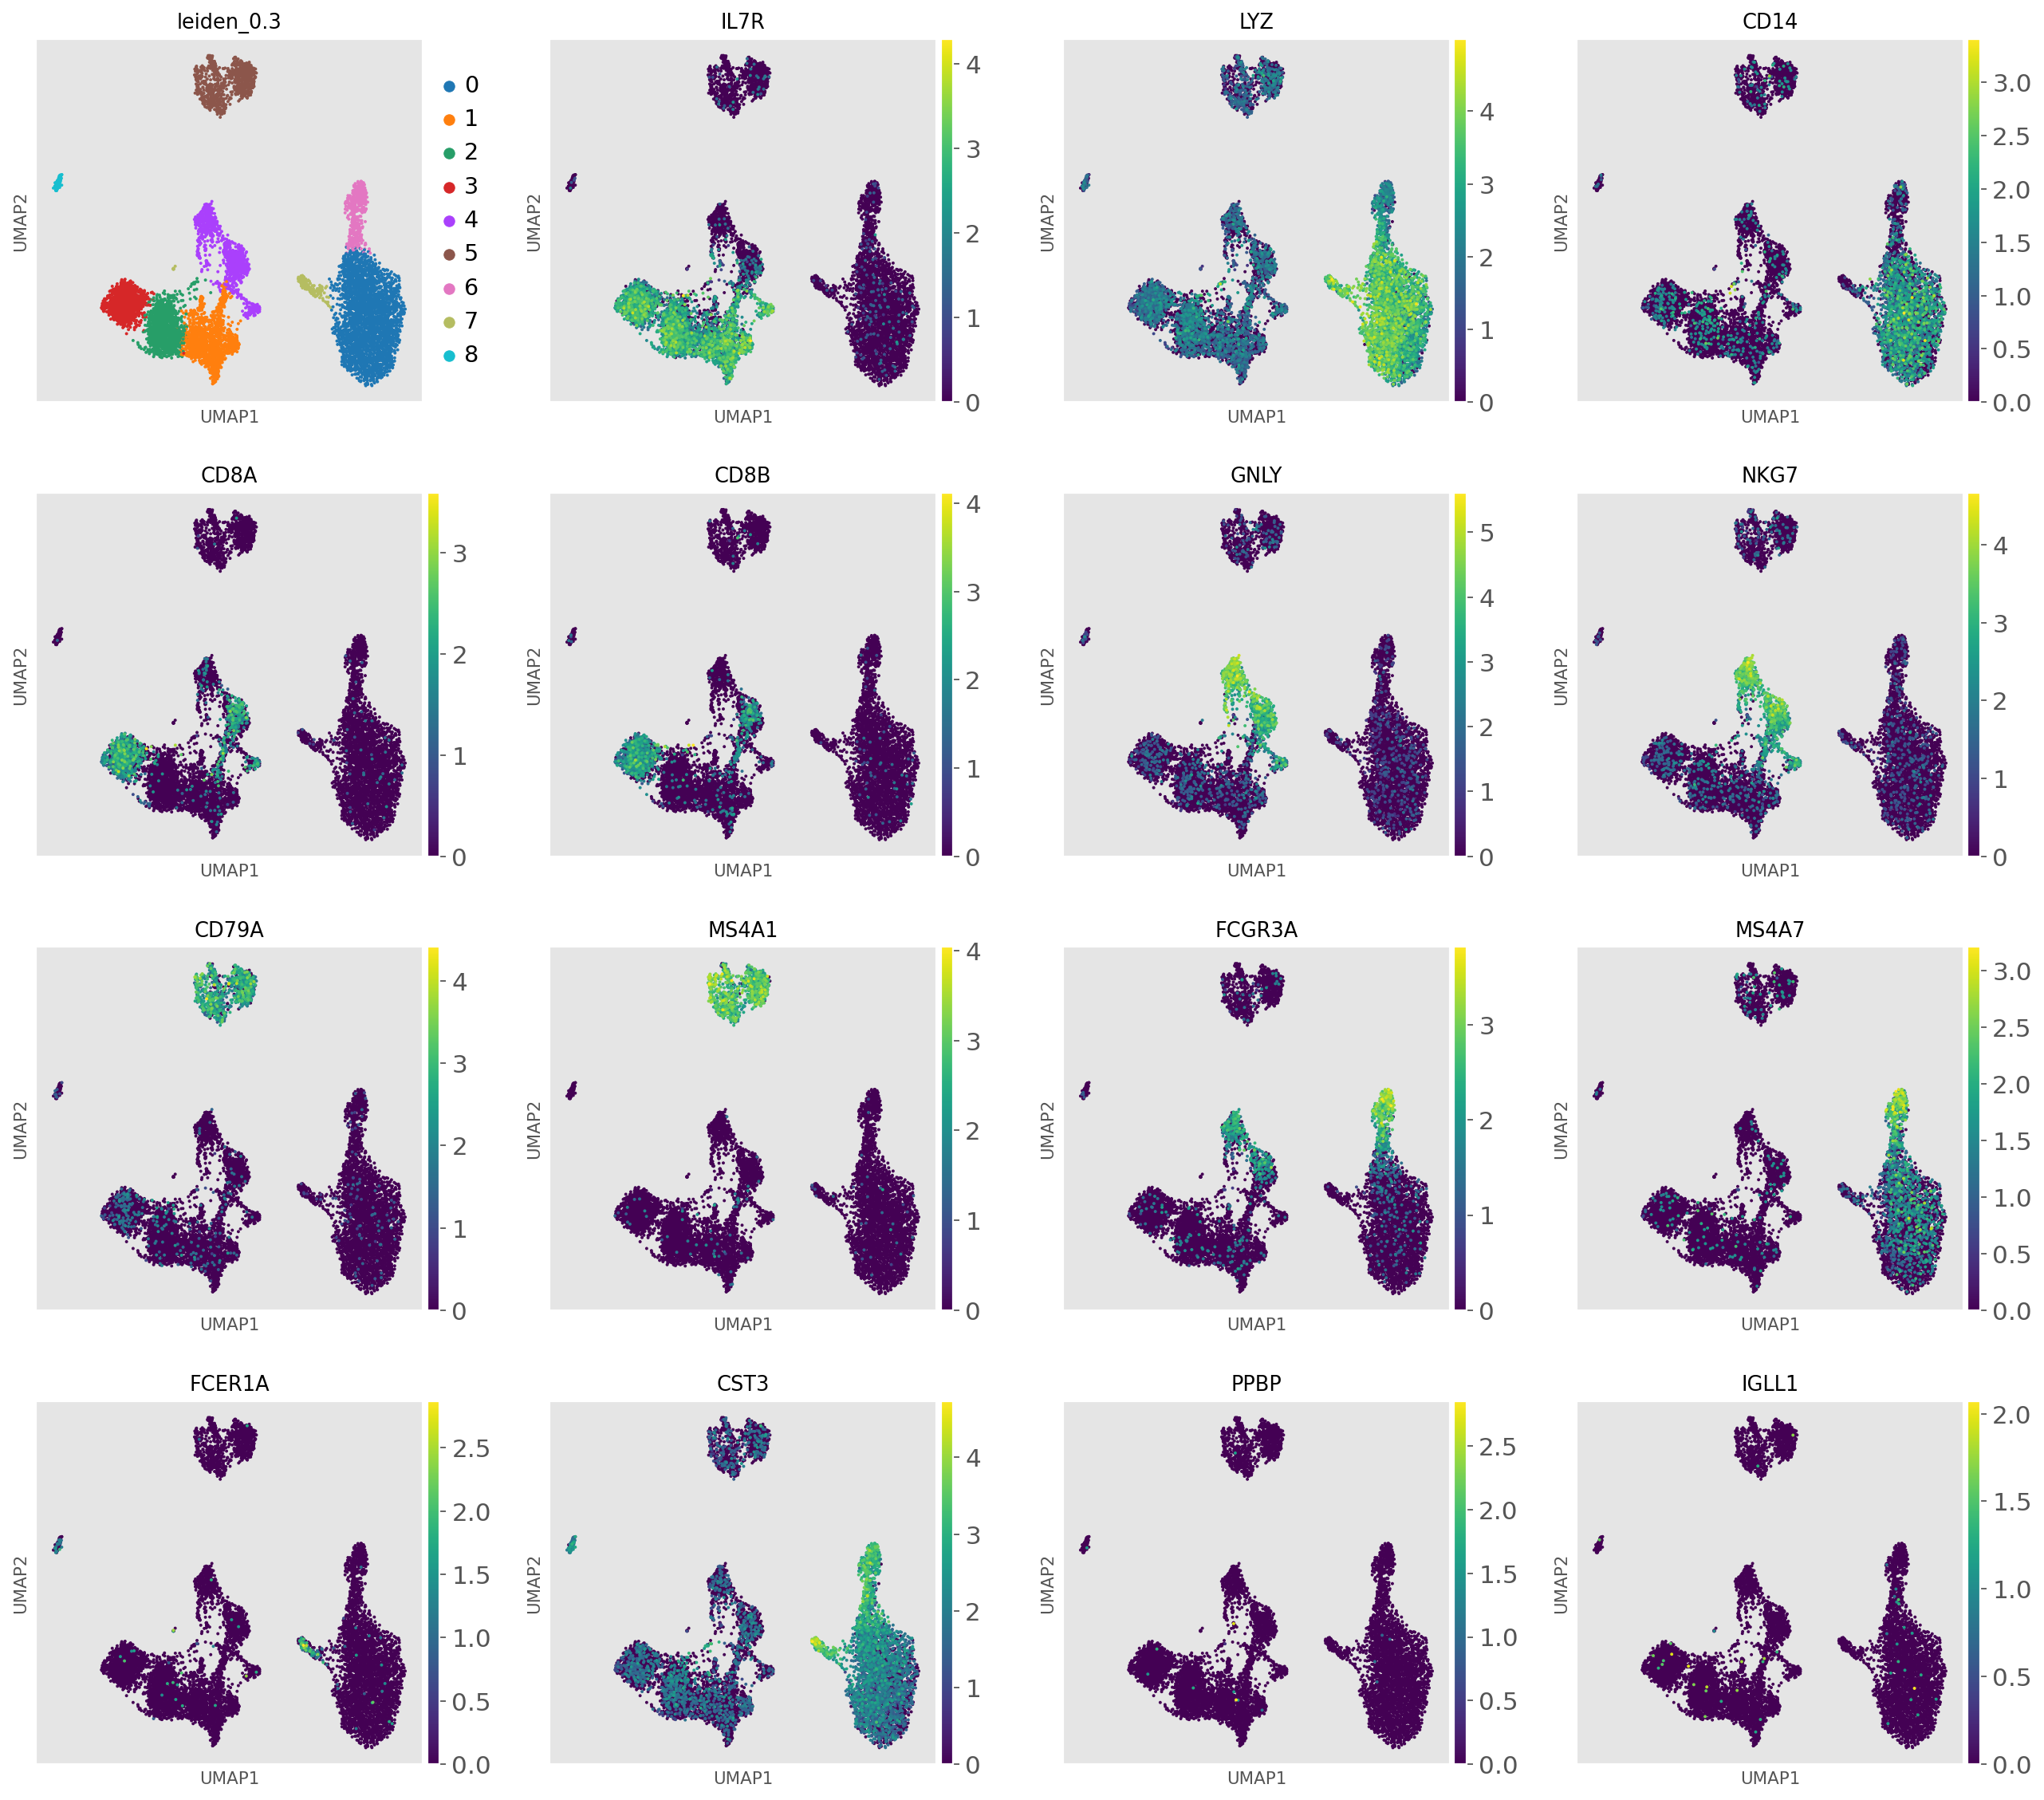

In [79]:
sc.pl.umap(adata, color=['leiden_0.3']+marker_genes)

In [80]:
marker_genes_dict = {
    'CD4 T Cells': ['IL7R'],
    'CD14+ Monocytes': ['CD14', 'LYZ'],
    'CD8 T Cells': ['CD8A','CD8B'],
    'NK Cells': ['GNLY', 'NKG7'],
    'B-cell': ['CD79A', 'MS4A1'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Megakaryocytes': ['PPBP'],
    'Other': ['IGLL1']
}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.3']`
categories: 0, 1, 2, etc.
var_group_labels: CD4 T Cells, CD14+ Monocytes, CD8 T Cells, etc.


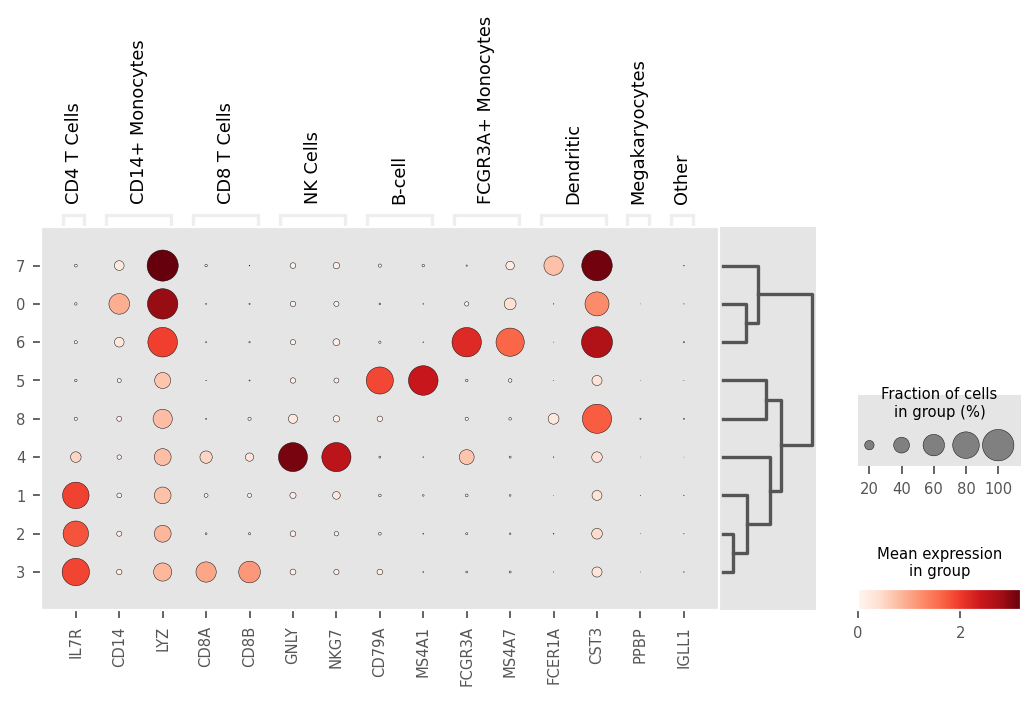

In [81]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden_0.3', dendrogram=True);

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.4']`
categories: 0, 1, 2, etc.
var_group_labels: CD4 T Cells, CD14+ Monocytes, CD8 T Cells, etc.


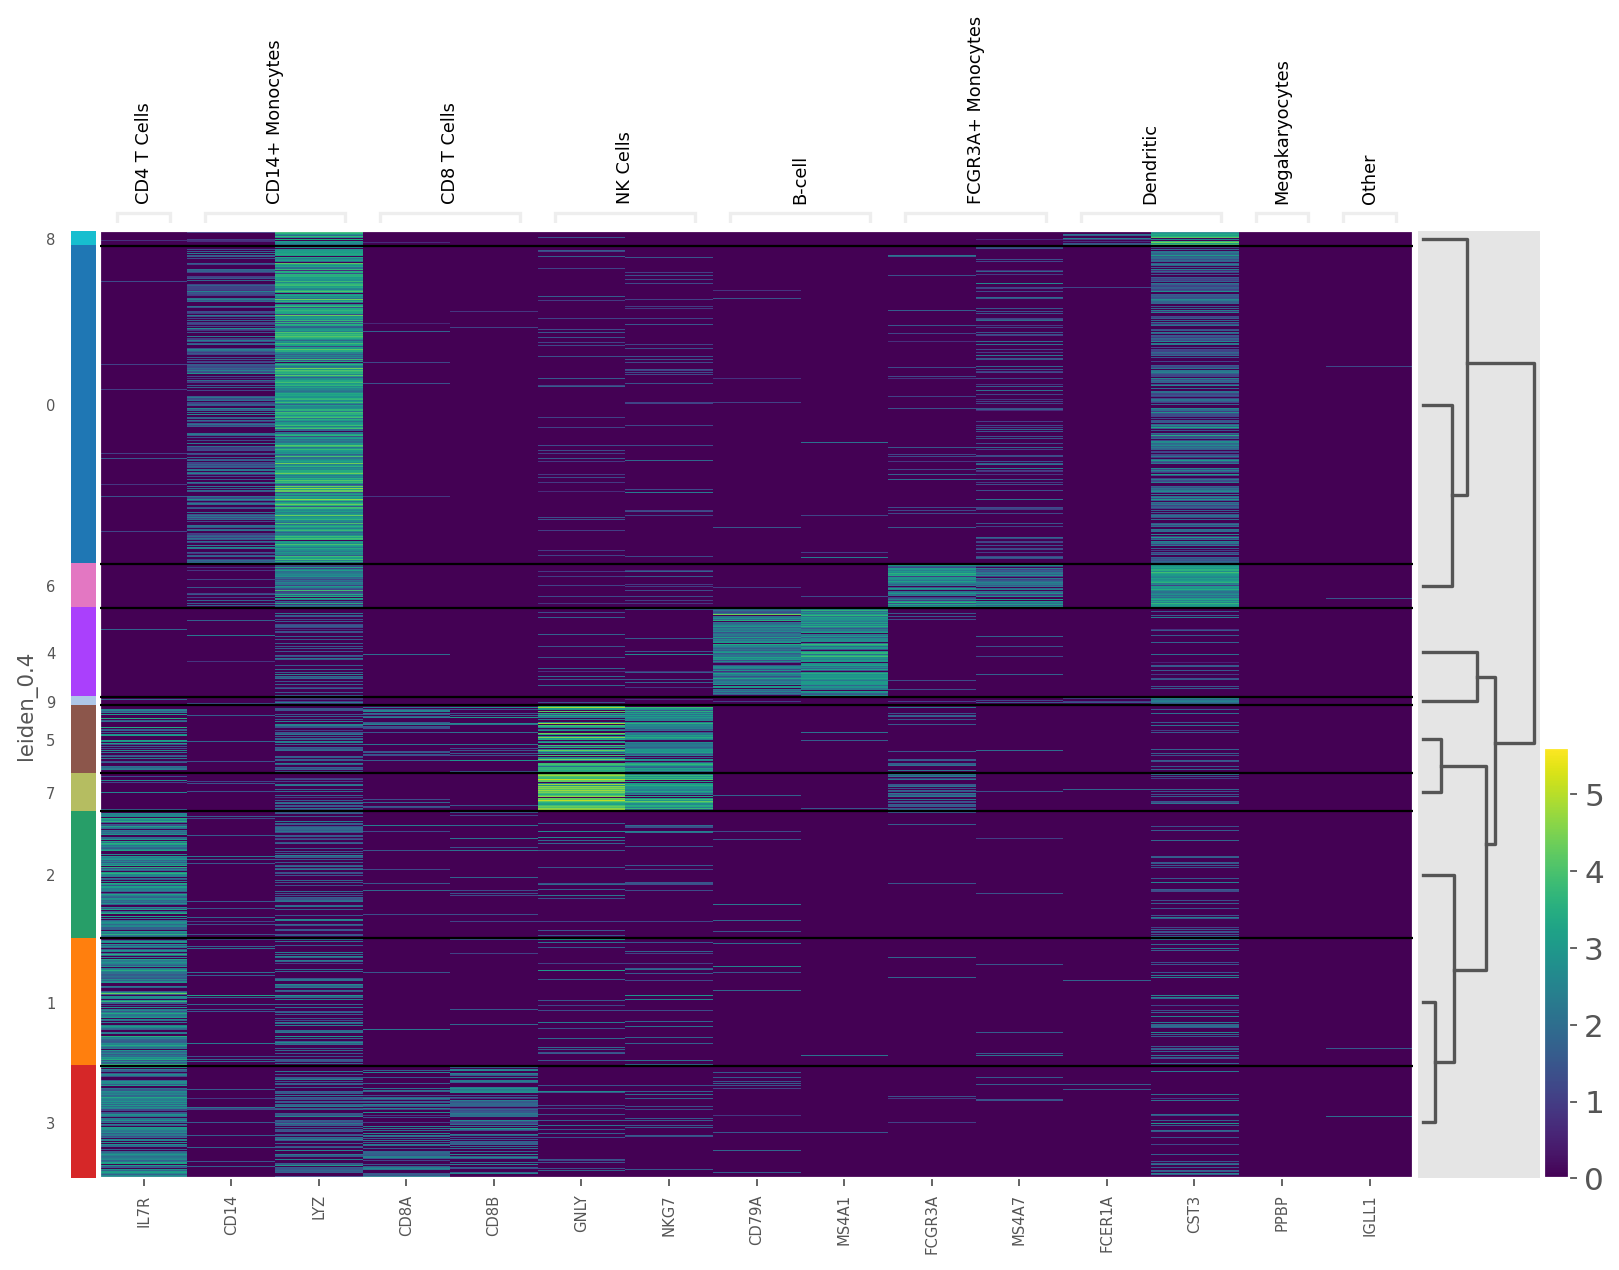

In [82]:
sc.pl.heatmap(adata, marker_genes_dict, groupby='leiden_0.4', cmap='viridis', dendrogram=True, figsize=(12,8))

In [97]:
cluster2annotation = {
     '0': 'CD14+_Monocytes',
     '1': 'CD4_T_Cells',
     '2': 'CD4_T_Cells',
     '3': 'CD8_T_Cells',
     '4': 'NK_Cells',
     '5': 'B_Cells',
     '6': 'FCGR3A+_Monocytes',
     '7': 'Dendritic_Cells_1',
     '8': 'Dendritic_Cells_2',
     '9': 'B_cells',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden_0.3'].map(cluster2annotation).astype('category')

In [98]:
plt.rcParams["figure.figsize"]=(12,8)
sc.pl.umap(adata, color='cell_type', legend_loc='on data',
           frameon=False, legend_fontsize=12, size=30, legend_fontoutline=2)

#### What makes dendritic cell 2 different from the others?

ranking genes
    finished (0:00:12)


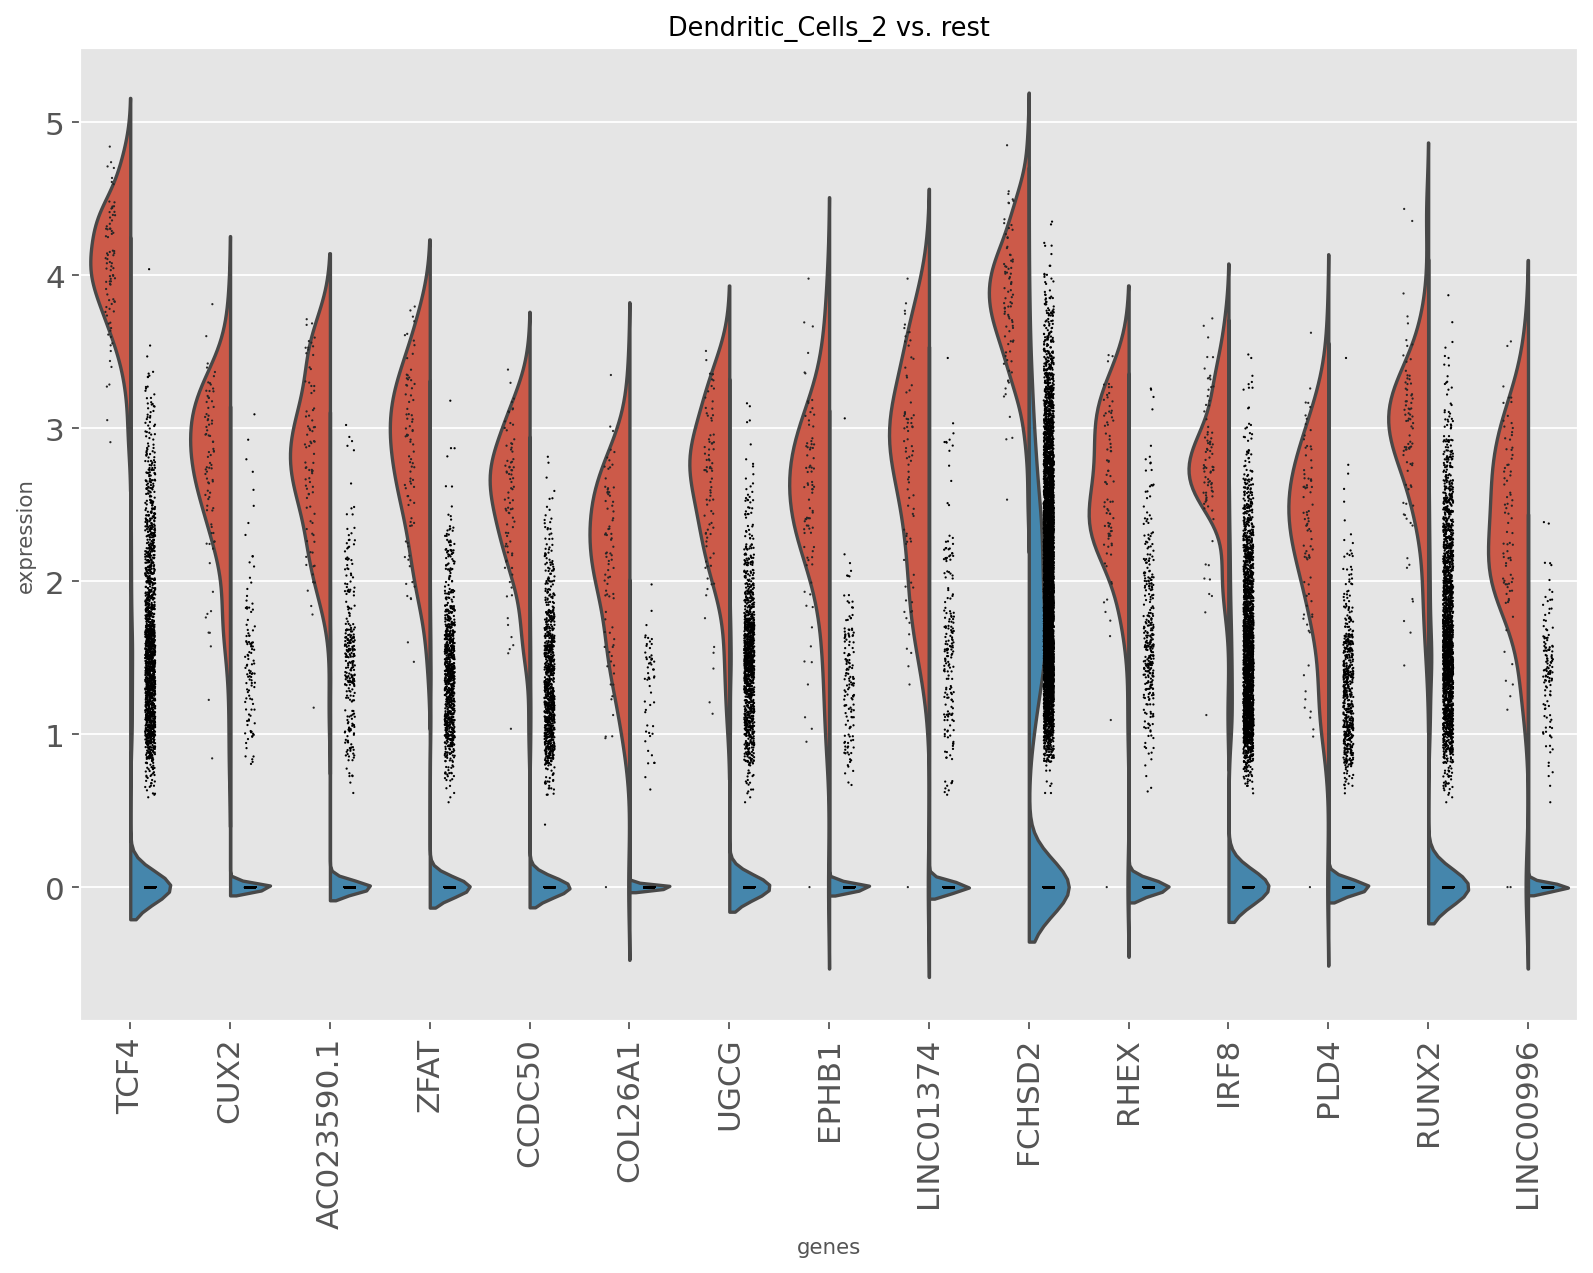

In [100]:
sc.tl.rank_genes_groups(adata, 'cell_type', groups=['Dendritic_Cells_2'], method='wilcoxon')
sc.pl.rank_genes_groups_violin(adata, groups='Dendritic_Cells_2', n_genes=15)

## Save files

In [102]:
adata.write("output/scanpy/pbmc10k_multi.h5ad")

In [103]:
lx = LoomX()
lx.modes.rna = (adata.raw.X, adata.raw.var.index, adata.obs.index)
lx.modes.rna.o.embeddings.umap = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res1 = pd.DataFrame(adata.obs["leiden_0.1"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res2 = pd.DataFrame(adata.obs["leiden_0.2"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res3 = pd.DataFrame(adata.obs["leiden_0.3"], index=adata.obs.index)
lx.modes.rna.o.clusterings.leiden_res4 = pd.DataFrame(adata.obs["leiden_0.4"], index=adata.obs.index)
lx.modes.rna.export(filename="./output/scanpy/pdmc10k_multi.loom", output_format="scope_v1")

INFO: Adding new rna mode
INFO: LoomX successfully exported to SCope-compatible loom file.


## Remarks
- By inspecting the marker genes provided by the PBMC3K tutorials, some clusters defined on the UMAP embeddings seem to belong to more than one cell type. This indicates the possibility of doublets.
- After cleaning doublets, the separation between clusters is much clearer, although some cell identities of the clusters remain ambiguous.

# Consensus of open chromatin regions with pycisTopic

In [57]:
import os
import pyranges as pr
import requests
import pickle
!module load MACS2

from pycisTopic.pseudobulk_peak_calling import *
from pycisTopic.iterative_peak_calling import *
from pycisTopic.qc import *
from pycisTopic.lda_models import *
from pycisTopic.clust_vis import *
import pybiomart as pbm

In [3]:
# ScanPy output
adata = sc.read("output/scanpy/pbmc10k_multi.h5ad")
# Path to fragments
fragments_dict = {'10x':'data/pbmc_unsorted_10k_atac_fragments.tsv.gz'}
# Path to regions
path_to_regions = 'output/pycistopic/consensus_peak_calling/consensus_regions.bed'
# Blacklist
path_to_blacklist='/data/leuven/338/vsc33883/git/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
infile = open('output/pycistopic/quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
infile = open('output/pycistopic/quality_control/bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()
# cisTopic object (removed observations not in ScanPy output)
infile = open('output/pycistopic/PBMC10k_ATAC_cisTopicObject_wRNA_wLDA.pkl', 'rb')
cistopic_obj_wRNA = pickle.load(infile)
infile.close()

## Getting pseudobulk profiles from scRNA-seq annotations

In [18]:
cell_data = adata.obs.loc[:,['cell_type','leiden_0.3']]
cell_data['sample_id'] = '10x'

In [91]:
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [106]:
ray.shutdown()
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'cell_type',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = 'output/pycistopic/consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path =  'output/pycistopic/consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = {'10x':'data/pbmc_unsorted_10k_atac_fragments.tsv.gz'},
                 n_cpu = 5,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/scratch/leuven/338/vsc33883/ray_spill')

2021-09-03 16:14:55,212 cisTopic     INFO     Reading fragments from data/pbmc_unsorted_10k_atac_fragments.tsv.gz


2021-09-03 16:21:05,721	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=36453) 2021-09-03 16:21:30,495 cisTopic     INFO     Creating pseudobulk for CD8_T_Cells
(pid=36452) 2021-09-03 16:21:30,610 cisTopic     INFO     Creating pseudobulk for CD4_T_Cells
(pid=36454) 2021-09-03 16:21:30,528 cisTopic     INFO     Creating pseudobulk for CD14+_Monocytes
(pid=36455) 2021-09-03 16:21:30,572 cisTopic     INFO     Creating pseudobulk for Dendritic_Cells_1
(pid=36456) 2021-09-03 16:21:30,540 cisTopic     INFO     Creating pseudobulk for B_Cells
(pid=36455) 2021-09-03 16:22:01,342 cisTopic     INFO     Dendritic_Cells_1 done!
(pid=36455) 2021-09-03 16:22:01,475 cisTopic     INFO     Creating pseudobulk for Dendritic_Cells_2
(pid=36455) 2021-09-03 16:22:14,757 cisTopic     INFO     Dendritic_Cells_2 done!
(pid=36455) 2021-09-03 16:22:14,896 cisTopic     INFO     Creating pseudobulk for FCGR3A+_Monocytes
(pid=36455) 2021-09-03 16:23:11,881 cisTopic     INFO     FCGR3A+_Monocytes done!
(pid=36455) 2021-09-03 16:23:12,015 cisTopic     INFO     Creating pseudobulk 

In [108]:
with open('output/pycistopic/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
    pickle.dump(bed_paths, f)
with open('output/pycistopic/consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl', 'wb') as f:
    pickle.dump(bw_paths, f)

## Inferring consensus peaks

In [109]:
macs_path='macs2'
outdir = 'output/pycistopic/consensus_peak_calling/MACS/'
# Run peak calling
ray.shutdown()
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 outdir,
                                 genome_size='hs',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = '/scratch/leuven/338/vsc33883/ray_spill')

2021-09-03 16:32:21,927	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=7865) 2021-09-03 16:32:48,079 cisTopic     INFO     Calling peaks for Dendritic_Cells_1 with macs2 callpeak --treatment output/pycistopic/consensus_peak_calling/pseudobulk_bed_files/Dendritic_Cells_1.bed.gz --name Dendritic_Cells_1  --outdir output/pycistopic/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(pid=7863) 2021-09-03 16:32:48,093 cisTopic     INFO     Calling peaks for CD4_T_Cells with macs2 callpeak --treatment output/pycistopic/consensus_peak_calling/pseudobulk_bed_files/CD4_T_Cells.bed.gz --name CD4_T_Cells  --outdir output/pycistopic/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(pid=7864) 2021-09-03 16:32:48,110 cisTopic     INFO     Calling peaks for CD14+_Monocytes with macs2 callpeak --treatment output/pycistopic/consensus_peak_calling/pseudobulk_bed_files/CD14+_Monocyt

In [110]:
with open('output/pycistopic/consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
    pickle.dump(narrow_peaks_dict, f)

In [115]:
# Other param
peak_half_width=250
path_to_blacklist='/data/leuven/338/vsc33883/git/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
ray.shutdown()
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2021-09-03 16:45:31,506 cisTopic     INFO     Extending and merging peaks per class
2021-09-03 16:46:48,162 cisTopic     INFO     Normalizing peak scores
2021-09-03 16:46:48,508 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2021-09-03 16:48:14,503 cisTopic     INFO     Done!


In [116]:
consensus_peaks.to_bed(path='output/pycistopic/consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)

## Quality Control

In [117]:
# Get TSS annotations
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')

annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

The default value of regex will change from True to False in a future version.


In [124]:
# Compute QC stats
fragments_dict = {'10x':'data/pbmc_unsorted_10k_atac_fragments.tsv.gz'}
path_to_regions = {'10x':'output/pycistopic/consensus_peak_calling/consensus_regions.bed'}

ray.shutdown()
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = '/scratch/leuven/338/vsc33883/ray_spill')

2021-09-03 16:57:36,697	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=21305) 2021-09-03 16:57:48,745 cisTopic     INFO     Reading 10x
(pid=21305) 2021-09-03 17:04:25,290 cisTopic     INFO     Computing barcode rank plot for 10x
(pid=21305) 2021-09-03 17:04:25,291 cisTopic     INFO     Counting fragments
(pid=21305) 2021-09-03 17:04:42,735 cisTopic     INFO     Marking barcodes with more than 100
(pid=21305) 2021-09-03 17:04:42,783 cisTopic     INFO     Returning plot data
(pid=21305) 2021-09-03 17:04:42,792 cisTopic     INFO     Returning valid barcodes
(pid=21305) 2021-09-03 17:05:08,713 cisTopic     INFO     Computing duplicate rate plot for 10x
(pid=21305) 2021-09-03 17:05:30,254 cisTopic     INFO     Return plot data
(pid=21305) 2021-09-03 17:05:30,413 cisTopic     INFO     Computing insert size distribution for 10x
(pid=21305) 2021-09-03 17:05:30,413 cisTopic     INFO     Counting fragments
(pid=21305) 2021-09-03 17:05:39,759 cisTopic     INFO     Returning plot data
(pid=21305) 2021-09-03 17:08:35,248 cisTopic     INFO     Computing TSS profi

In [126]:
with open('output/pycistopic/quality_control/metadata_bc.pkl', 'wb') as f:
    pickle.dump(metadata_bc, f)

In [127]:
with open('output/pycistopic/quality_control/profile_data_dict.pkl', 'wb') as f:
    pickle.dump(profile_data_dict, f)

### Sample level statistics

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


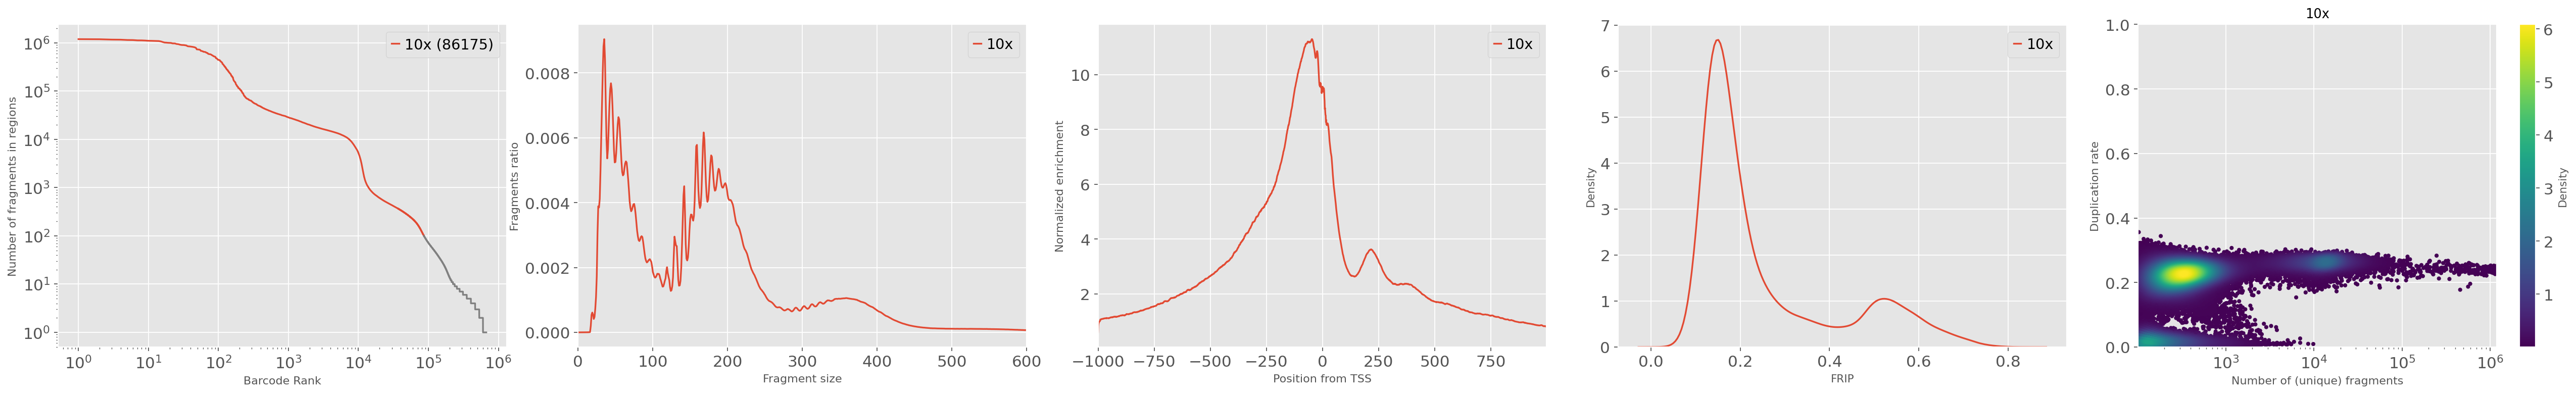

In [128]:
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save='output/pycistopic/quality_control/sample_metrics.pdf')

#### Remarks
- **Barcode rank plot**: Seems to be two-step instead of one-step? Could it be due to existence of doublets?
- **Insertion size**: Clear separation of two peaks indicates open chromatin regions (<100bp) and mononucleosomes (~200) respectively.
- **Sample TSS enrichment**: Most reads surround TSSs.
- **FRIP distribution**: Most reads have low FRIP score, meaning they tend not to fall into peak regions. This indicates the data is noisy.
- **Duplication rate**: Duplication rate is low, meaning most reads are usable.

### Barcode level statistics

In [132]:
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save='output/pycistopic/quality_control/barcode_metrics/FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save='output/pycistopic/quality_control/barcode_metrics/TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histpl

In [133]:
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

### Filtering

In [134]:
bc_passing_filters = {}
bc_passing_filters['10x'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))

In [144]:
len(set(bc_passing_filters['10x']) & set(cell_data.index.unique()))

8475

In [145]:
with open('output/pycistopic/quality_control/bc_passing_filters.pkl', 'wb') as f:
    pickle.dump(bc_passing_filters, f)

## Creating cisTopic object

In [154]:
ray.shutdown()
cistopic_obj=create_cistopic_object_from_fragments(path_to_fragments=fragments_dict['10x'],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc['10x'],
                                               valid_bc=bc_passing_filters['10x'],
                                               n_cpu=1,
                                               project='10x')

2021-09-03 18:15:49,425 cisTopic     INFO     Reading data for 10x
2021-09-03 18:21:35,646 cisTopic     INFO     metrics provided!
2021-09-03 18:21:53,357 cisTopic     INFO     valid_bc provided, selecting barcodes!
2021-09-03 18:22:06,732 cisTopic     INFO     Counting fragments in regions
2021-09-03 18:23:24,987 cisTopic     INFO     Creating fragment matrix
2021-09-03 18:23:55,049 cisTopic     INFO     Data is too big, making partitions. This is a reported error in Pandas versions > 0.21 (https://github.com/pandas-dev/pandas/issues/26314)
2021-09-03 18:24:38,402 cisTopic     INFO     Converting fragment matrix to sparse matrix
2021-09-03 18:24:45,280 cisTopic     INFO     Removing blacklisted regions
2021-09-03 18:24:46,550 cisTopic     INFO     Creating CistopicObject
2021-09-03 18:24:47,568 cisTopic     INFO     Done!
2021-09-03 18:25:09,411 cisTopic     INFO     Converting fragment matrix to sparse matrix
2021-09-03 18:25:17,720 cisTopic     INFO     Removing blacklisted regions


In [12]:
with open('output/pycistopic/PBMC10k_ATAC_cisTopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)

In [22]:
cistopic_obj.add_cell_data(cell_data)

Columns ['sample_id'] will be overwritten


In [25]:
# Remove cells without RNA counterpart
rna_cells = cistopic_obj.cell_data.dropna().index.tolist()
# Subset cisTopic object
cistopic_obj_wRNA = cistopic_obj.subset(rna_cells, copy=True)
print(cistopic_obj_wRNA)

CistopicObject from project 10x with n_cells × n_regions = 8475 × 287049


In [26]:
with open('output/pycistopic/PBMC10k_ATAC_cisTopicObject_wRNA.pkl', 'wb') as f:
    pickle.dump(cistopic_obj_wRNA, f)

## Run LDA models

In [5]:
models=run_cgs_models(cistopic_obj_wRNA,
                    n_topics=[2,5,10,15,20,25,30,35,40,45,50],
                    n_cpu=18,
                    n_iter=100,
                    random_state=1,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None)

2021-09-08 15:52:18,463	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8266


(pid=4427) 2021-09-08 15:52:44,176 cisTopic     INFO     Running model with 40 topics
(pid=4422) 2021-09-08 15:52:44,219 cisTopic     INFO     Running model with 20 topics
(pid=4428) 2021-09-08 15:52:44,271 cisTopic     INFO     Running model with 5 topics
(pid=4425) 2021-09-08 15:52:44,426 cisTopic     INFO     Running model with 50 topics
(pid=4416) 2021-09-08 15:52:44,424 cisTopic     INFO     Running model with 45 topics
(pid=4421) 2021-09-08 15:52:44,404 cisTopic     INFO     Running model with 35 topics
(pid=4420) 2021-09-08 15:52:44,424 cisTopic     INFO     Running model with 30 topics
(pid=4429) 2021-09-08 15:52:44,432 cisTopic     INFO     Running model with 25 topics
(pid=4430) 2021-09-08 15:52:44,412 cisTopic     INFO     Running model with 15 topics
(pid=4432) 2021-09-08 15:52:44,428 cisTopic     INFO     Running model with 10 topics
(pid=4431) 2021-09-08 15:52:44,403 cisTopic     INFO     Running model with 2 topics


(raylet) lsof: WARNING: can't stat() nfs4 file system /vsc-mounts/antwerpen-apps
(raylet)       Output information may be incomplete.


(pid=4431) 2021-09-08 16:06:15,802 cisTopic     INFO     Model with 2 topics done!
(pid=4428) 2021-09-08 16:10:36,818 cisTopic     INFO     Model with 5 topics done!
(pid=4432) 2021-09-08 16:20:21,593 cisTopic     INFO     Model with 10 topics done!
(pid=4430) 2021-09-08 16:27:50,340 cisTopic     INFO     Model with 15 topics done!
(pid=4422) 2021-09-08 16:35:33,097 cisTopic     INFO     Model with 20 topics done!
(pid=4429) 2021-09-08 16:41:23,786 cisTopic     INFO     Model with 25 topics done!
(pid=4420) 2021-09-08 16:55:02,189 cisTopic     INFO     Model with 30 topics done!
(pid=4421) 2021-09-08 17:02:55,562 cisTopic     INFO     Model with 35 topics done!
(pid=4427) 2021-09-08 17:10:47,451 cisTopic     INFO     Model with 40 topics done!
(pid=4416) 2021-09-08 17:18:25,047 cisTopic     INFO     Model with 45 topics done!
(pid=4425) 2021-09-08 17:26:04,507 cisTopic     INFO     Model with 50 topics done!


In [6]:
with open('output/pycistopic/models/PBMC10k_ATAC_models_500_iter.pkl', 'wb') as f:
    pickle.dump(models, f)

In [8]:
model=evaluate_models(models,
                     select_model=35, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     )

In [12]:
cistopic_obj_wRNA.add_LDA_model(model)
cistopic_obj = cistopic_obj_wRNA

In [10]:
with open('output/pycistopic/PBMC10k_ATAC_cisTopicObject_wRNA_wLDA.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)

## Clustering

In [18]:
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = [0.3, 0.5], 
                 prefix = 'pycisTopic_', 
                 scale = True)

2021-09-08 18:14:16,339 cisTopic     INFO     Finding neighbours


In [19]:
run_umap(cistopic_obj,
                 target  = 'cell', scale=True)

2021-09-08 18:14:19,210 cisTopic     INFO     Running UMAP


Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


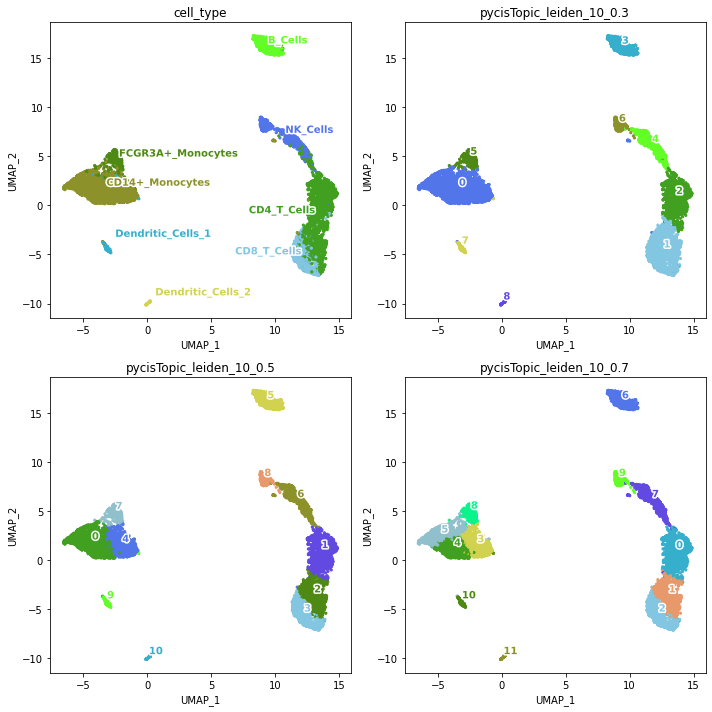

In [21]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['cell_type', 'pycisTopic_leiden_10_0.3', 'pycisTopic_leiden_10_0.5'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,10))

In [27]:
annot_dict = {}
annot_dict['pycisTopic_leiden_10_0.3'] = {'0':'CD14+_Monocytes_(0)',
                                          '1':'CD4/8_T_Cells_(1)',
                                          '2':'CD4_T_Cells_(2)',
                                          '3':'B_Cells_(3)',
                                          '4':'NK_Cells_(4)',
                                          '5':'FCGR3A+_Monocytes_(5)',
                                          '6':'NK_Cells_(6)',
                                          '7':'Dendritic_Cells_1_(7)',
                                          '8':'Dendritic_Cells_2_(8)'}
annot_dict['pycisTopic_leiden_10_0.5'] = {'0':'CD14+_Monocytes_(0)',
                                          '1':'CD4_T_Cells_(1)',
                                          '2':'CD4_T_Cells_(2)',
                                          '3':'CD8_T_Cells(3)',
                                          '4':'CD14+_Monocytes_(4)',
                                          '5':'B_Cells_(5)',
                                          '6':'NK_Cells_(6)',
                                          '7':'FCGR3A+_Monocytes_(7)',
                                          '8':'NK_Cells_(8)',
                                          '9':'Dendritic_Cells_1_(9)',
                                          '10':'Dendritic_Cells_2_(10)'}
cistopic_obj.cell_data['pycisTopic_leiden_10_0.3'] = [annot_dict['pycisTopic_leiden_10_0.3'][x] 
                                                      for x in cistopic_obj.cell_data['pycisTopic_leiden_10_0.3'].tolist()]
cistopic_obj.cell_data['pycisTopic_leiden_10_0.5'] = [annot_dict['pycisTopic_leiden_10_0.5'][x] 
                                                      for x in cistopic_obj.cell_data['pycisTopic_leiden_10_0.5'].tolist()]

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


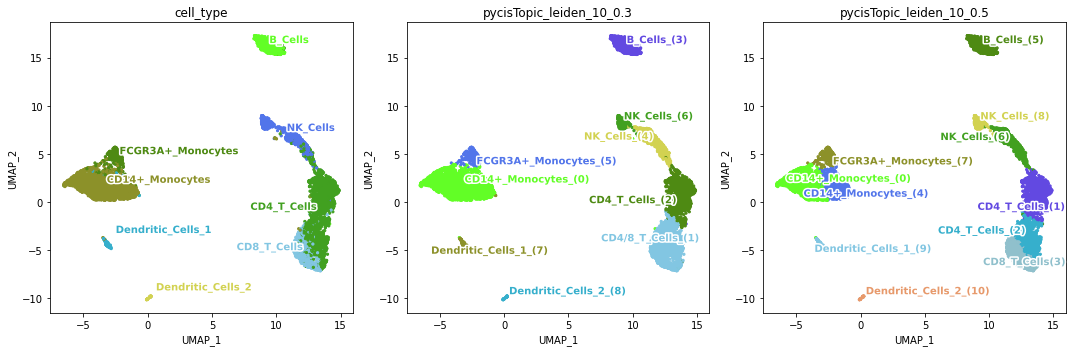

In [36]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['cell_type', 'pycisTopic_leiden_10_0.3', 'pycisTopic_leiden_10_0.5'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 text_size=10,
                 dot_size=5,
                 figsize=(15,5))

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


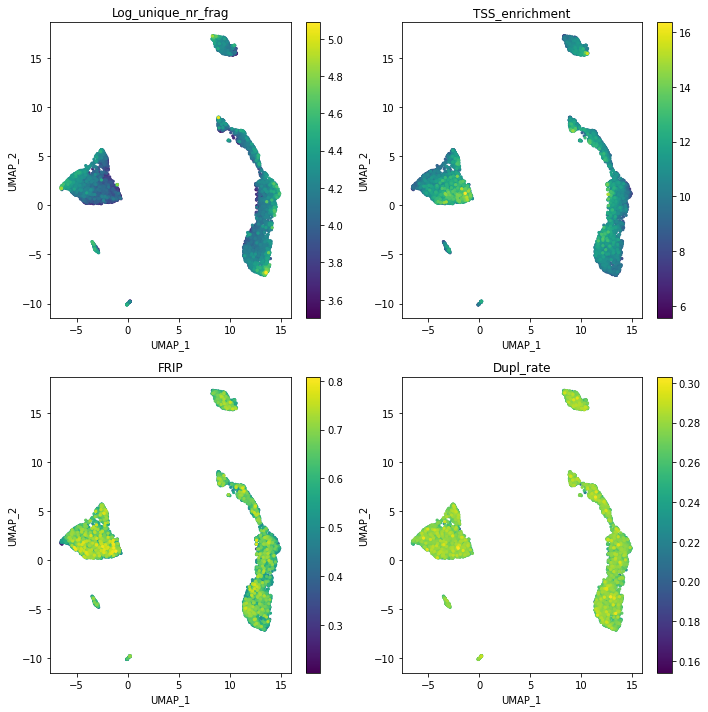

In [33]:
# Check statistics
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Log_unique_nr_frag', 'TSS_enrichment', 'FRIP', 'Dupl_rate'], 
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,10))

In [39]:
# Plot topic distributions
plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=4)

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


In [63]:
cell_topic_heatmap(cistopic_obj,
                     variables = ['cell_type'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,10))

NotImplementedError: isna is not defined for MultiIndex

In [64]:
with open('output/pycistopic/PBMC10k_ATAC_cisTopicObject_wRNA_wLDA.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)